# **Project 1 − Cosmological Models**
## Advanced Simulation and Machine Learning | TIF345
## Chalmers University of Technology | Fall 2025
---
### Linus Brink | [brinkl@chalmers.se](mailto:brinkl@chalmers.se) 
### Oscar Stommendal | [oscarsto@chalmers.se](mailto:oscarsto@chalmers.se)
---

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy.stats as stats

plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'


## **Task 1: Infer $H_0$ and $q_0$ based on the data set**

In [63]:
### Read data and define simulation parameters ###

data = np.loadtxt("data/SCPUnion2.1_mu_vs_z.txt", comments="#", usecols=(1,2,3,4))
z = data[:, 0] # redshift
mu_obs = data[:, 1] # observed distance modulus
mu_err = data[:, 2] # error in distance modulus
data_sys = data[:, 3] # systematic error in distance modulus

c = 299792.458 # speed of light in km/s
H0_min, H0_max = 30, 100 # Hubble constant prior range in km/s/Mpc
q0_min, q0_max = -2, 2 # Deceleration parameter prior range
inv_gamma_a = 1.0 # inverse gamma parameter for systematic error model
inv_gamma_scale = 0.1 # inverse gamma scale for systematic error model

# H0 check
mini_z = z[z < 0.05]
d_L = (10**((mu_obs[z < 0.05] + 5) / 5)) / 1e6 # in Mpc
H_0 = c * mini_z / d_L
print(f"Estimated H0 from low-z data: {np.median(H_0):.2f} ± {np.std(H_0):.2f} km/s/Mpc")


Estimated H0 from low-z data: 68.31 ± 5.75 km/s/Mpc


In [ ]:
### Functions for MCMC ###

def mu_theory(z, H0, q0, c):
    """Calculate the theoretical distance modulus for given cosmological parameters."""
    dL_MPc = c / H0 *(z + 0.5 * (1 - q0) * z**2) # Luminosity distance in Mpc
    mu = 5 * np.log10(dL_MPc) + 25
    return mu

def log_prior(theta):
    """Calculate the log prior probability for the parameters."""
    H0, q0, sigma_sys = theta
    if H0_min < H0 < H0_max and q0_min < q0 < q0_max and sigma_sys > 0:
        logp_sigma_sys = stats.invgamma.logpdf(sigma_sys, a=inv_gamma_a, scale=inv_gamma_scale)
        return logp_sigma_sys
    return -np.inf

def log_likelihood(theta, z, mu_obs, mu_err):
    """Calculate the log likelihood of the observed data given the model parameters."""
    H0, q0, sigma_sys = theta
    mu_model = mu_theory(z, H0, q0, c)
    var = mu_err**2 + sigma_sys**2
    if np.any(var <= 0):
        return -np.inf
    total_err = np.sqrt(var)
    if np.any(np.isnan(mu_model)):
        return -np.inf
    logL = -0.5 * np.sum(((mu_obs - mu_model) / total_err)**2 + np.log(2 * np.pi * total_err**2))
    return logL

def log_posterior(theta, z, mu_obs, mu_err):
    """Calculate the log posterior probability for the parameters given the data."""
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, mu_obs, mu_err)


In [33]:
### Run MCMC ###

ndim = 3
nwalkers = 100

# Initial guess: H0 ~70, q0 ~ -0.5, s2 ~1
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = 70.0 + 10 * np.random.randn(nwalkers)
p0[:,1] = -0.5 + 1e-1 * np.random.randn(nwalkers)
p0[:,2] = np.log(1.0) + 1e-1 * np.random.randn(nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z, mu_obs, mu_err))
print("Running burn-in...")
pos, prob, state = sampler.run_mcmc(p0, 1000, progress=True)
sampler.reset()
print("Running production...")
sampler.run_mcmc(pos, 5000, progress=True)

samples = sampler.get_chain(flat=True)
H0_samples = samples[:,0]
q0_samples = samples[:,1]
s2_samples = np.exp(samples[:,2])


Running burn-in...


  0%|          | 0/1000 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:24<00:00, 40.48it/s]


Running production...


100%|██████████| 5000/5000 [02:11<00:00, 38.15it/s]


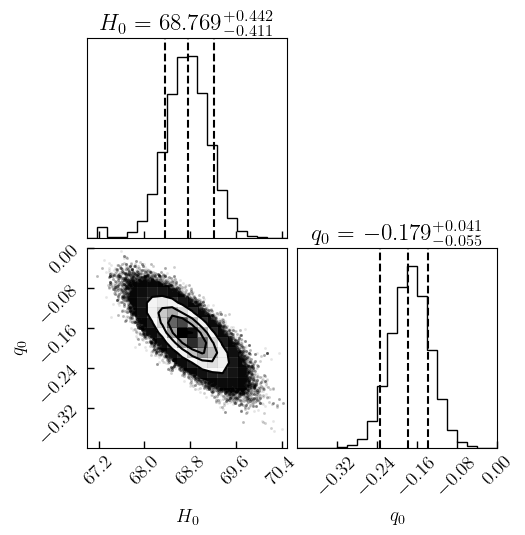

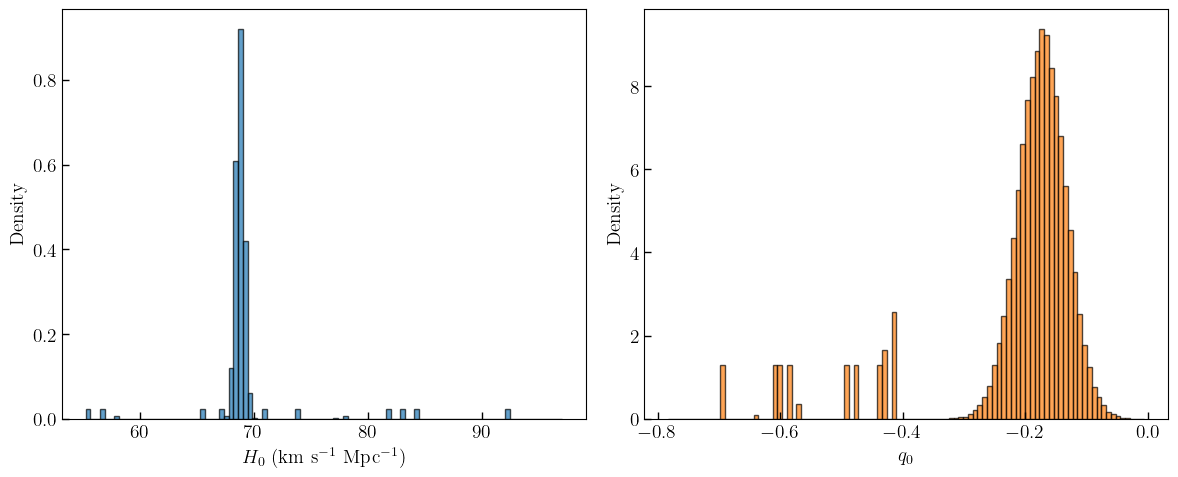

In [58]:
### Results ###

# Corner plot
fig = corner.corner(np.vstack([H0_samples, q0_samples]).T,
                    labels=[r"$H_0$", r"$q_0$"],
                    range=[[67, 70.5], [-0.4, 0.0]],
                    show_titles=True,
                    title_fmt=".3f",
                    quantiles=[0.16, 0.5, 0.84])
# fig.savefig("posterior_corner.png")

# Histograms of individual parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(H0_samples, bins=100, density=True, color='tab:blue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel(r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)")
axes[0].set_ylabel("Density")
axes[1].hist(q0_samples, bins=100, density=True, color='tab:orange', alpha=0.7, edgecolor='black')
axes[1].set_xlabel(r"$q_0$")
axes[1].set_ylabel("Density")
plt.tight_layout()
# plt.savefig("posterior_histograms.png")
plt.show()


In [ ]:
### Posterior predictive plot of distance modulus ###

z_plot = np.linspace(0.01, 1.5, 100)
mu_model_samples = np.array([mu_theory(z_plot, H0, q0, c) for H0, q0 in zip(H0_samples, q0_samples)])
mu_model_median = np.median(mu_model_samples, axis=0)



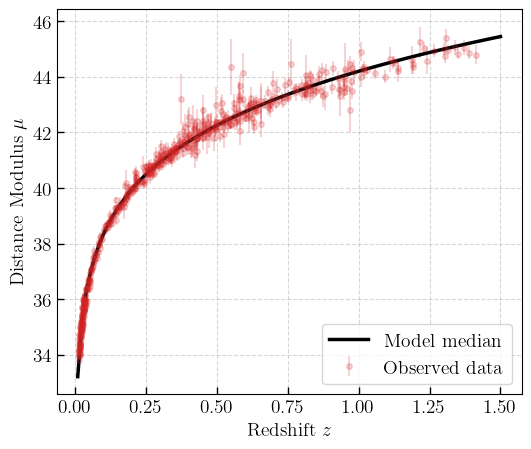

In [ ]:

plt.figure(figsize=(6,5))

plt.errorbar(z, mu_obs, yerr=mu_err, fmt='o', label='Observed data', alpha=0.2, color='tab:red', markersize=4)
plt.plot(z_plot, mu_model_median, color='k', label='Model median', linewidth=2.5)
plt.xlabel("Redshift $z$")
plt.ylabel("Distance Modulus $\\mu$")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()